In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchtext
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
TEXT = torchtext.data.Field(lower=True, include_lengths=True,fix_length=1000, batch_first=True)
LABEL = torchtext.data.Field(sequential=False)

In [3]:
train, test = torchtext.datasets.IMDB.splits(TEXT, LABEL)

In [4]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [5]:
train_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, test), batch_size=32, device=0)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [65]:
class LSTM_Classifier(nn.Module):
    
    def __init__(self, embed_dim = 128, hidden_dim = 128, seq_length = 1000):
        super(LSTM_Classifier,self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        
        self.embed = nn.Embedding(len(TEXT.vocab),embed_dim)
        self.rnn = nn.LSTM(embed_dim,hidden_dim,1, batch_first=True)
        self.fc = nn.Linear(hidden_dim,1)

#         self.hidden = self.init_hidden()
    
#     def init_hidden(self):
#         return (Variable(torch.zeros(1,self.seq_length,self.hidden_dim).cuda()), 
#                 Variable(torch.zeros(1,self.seq_length,self.hidden_dim).cuda()))
    
    def forward(self,x):
        tmp = self.embed(x) # Batch_size, Seq_len, Hidden_dim 
        tmp, (ht,ct) = self.rnn(tmp)
        tmp = self.fc(ht[-1])
        
        return tmp

In [75]:
model = LSTM_Classifier().cuda()

In [67]:
## 測試 forward
for i in train_iter:
    text = i.text[0].cuda()
    output = model(text)
    print(output.shape)
    break

torch.Size([32, 1])


In [76]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters())

In [77]:
epoches = 20

In [78]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_iter):
        text = data.text[0].cuda()
        label = data.label.view(-1,1).float().cuda()-1
        
        output = model(text)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward(retain_graph=True)
        optim.step()
        
        running_loss += loss.item()
    training_loss.append(running_loss/len(train))
    print(f'epoch {e+1} : {running_loss/len(train)}')

  0%|                                                                                  | 1/782 [00:00<01:36,  8.13it/s]

epoch 1 : 0.02172059292078018


  0%|                                                                                  | 1/782 [00:00<01:38,  7.97it/s]

epoch 2 : 0.021684429438114165


  0%|                                                                                  | 1/782 [00:00<01:33,  8.33it/s]

epoch 3 : 0.0216685595536232


  0%|                                                                                  | 1/782 [00:00<01:38,  7.94it/s]

epoch 4 : 0.021642211532592773


  0%|                                                                                  | 1/782 [00:00<01:37,  8.00it/s]

epoch 5 : 0.021635055747032166


  0%|                                                                                  | 1/782 [00:00<01:33,  8.33it/s]

epoch 6 : 0.02163088938474655


  0%|                                                                                  | 1/782 [00:00<01:38,  7.94it/s]

epoch 7 : 0.020303301759958266


  0%|                                                                                  | 1/782 [00:00<01:38,  7.94it/s]

epoch 8 : 0.019493218212127687


  0%|                                                                                  | 1/782 [00:00<01:34,  8.27it/s]

epoch 9 : 0.013175621345043182


  0%|                                                                                  | 1/782 [00:00<01:36,  8.07it/s]

epoch 10 : 0.008043710705339909


  0%|                                                                                  | 1/782 [00:00<01:36,  8.13it/s]

epoch 11 : 0.0050762546260654925


  0%|                                                                                  | 1/782 [00:00<01:36,  8.06it/s]

epoch 12 : 0.00335910588119179


  0%|                                                                                  | 1/782 [00:00<01:40,  7.75it/s]

epoch 13 : 0.0023260123922862115


  0%|                                                                                  | 1/782 [00:00<01:34,  8.26it/s]

epoch 14 : 0.0016734921051934362


  0%|                                                                                  | 1/782 [00:00<01:34,  8.26it/s]

epoch 15 : 0.0012111967927310617


  0%|                                                                                  | 1/782 [00:00<01:33,  8.33it/s]

epoch 16 : 0.0010391221177577972


  0%|                                                                                  | 1/782 [00:00<01:35,  8.20it/s]

epoch 17 : 0.0009042498605512083


  0%|                                                                                  | 1/782 [00:00<01:32,  8.47it/s]

epoch 18 : 0.00048749932071426885


  0%|                                                                                  | 1/782 [00:00<01:35,  8.20it/s]

epoch 19 : 0.0005279751194338314


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [01:10<00:00, 11.14it/s]

epoch 20 : 0.0003776445251866244


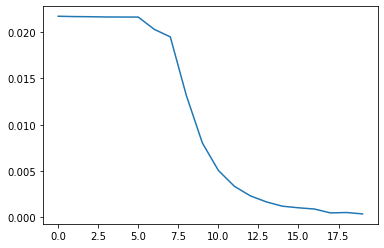

In [79]:
plt.plot(training_loss)

In [80]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    for data in tqdm(test_iter):
        text = data.text[0].cuda()
        label = (data.label.cuda()-1).byte().view(-1,1)
        
        output = model(text)
        pred = output.sigmoid() >0.5
        pred = torch.sum(pred == label)
        running_hit += pred.item()
    print(running_hit/len(test))

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:22<00:00, 35.48it/s]

0.84848


In [81]:
torch.save(model.state_dict(),'lstm.pth')